### SSR and FROLs (the greedy algorithms!) examples
SSR algorithm based on Boninsegna, L., Nüske, F., & Clementi, C. (2018). Sparse learning of stochastic dynamical equations. The Journal of chemical physics, 148(24), 241723 and FROLS algorithm based on Billings, S. A. (2013). Nonlinear system identification: NARMAX methods in the time, frequency, and spatio-temporal domains. John Wiley & Sons.
Jupyter notebook written by Alan Kaptanoglu and Jared Callaham.

Stepwise sparse regression (SSR) solves the problem by iteratively truncating the smallest coefficient during the optimization. There are many ways one can decide to truncate terms. We implement two popular ways: (1) truncating the smallest coefficient at each iteration; (2) chopping each coefficient, computing N - 1 models, and then choosing the model with the lowest residual error.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

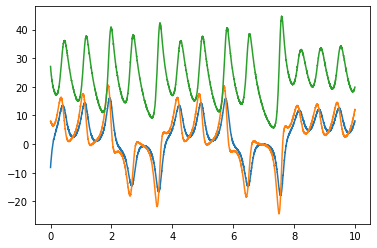

In [2]:
# Generate some training data with added gaussian noise
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

dt = .002
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_train = x_train + np.random.normal(0, 0.1, x_train.shape)
ssr_optimizer = ps.SSR(alpha=.05)

model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

for i in range(3):
    plt.plot(t_train, x_train[:, i])

Note that the usage is a bit different because we save all the sparse models and we choose our favorite one afterwards. Below we show Model 4 has the lowest MSE between the predicted and true derivative, so we could use this to choose our model. 

Model 0, MSE: 0.137894
Model 1, MSE: 0.132621
Model 2, MSE: 0.115010
Model 3, MSE: 0.087668
Model 4, MSE: 0.068365
Model 5, MSE: 0.039036
Model 6, MSE: 0.033635
Model 7, MSE: 0.036118


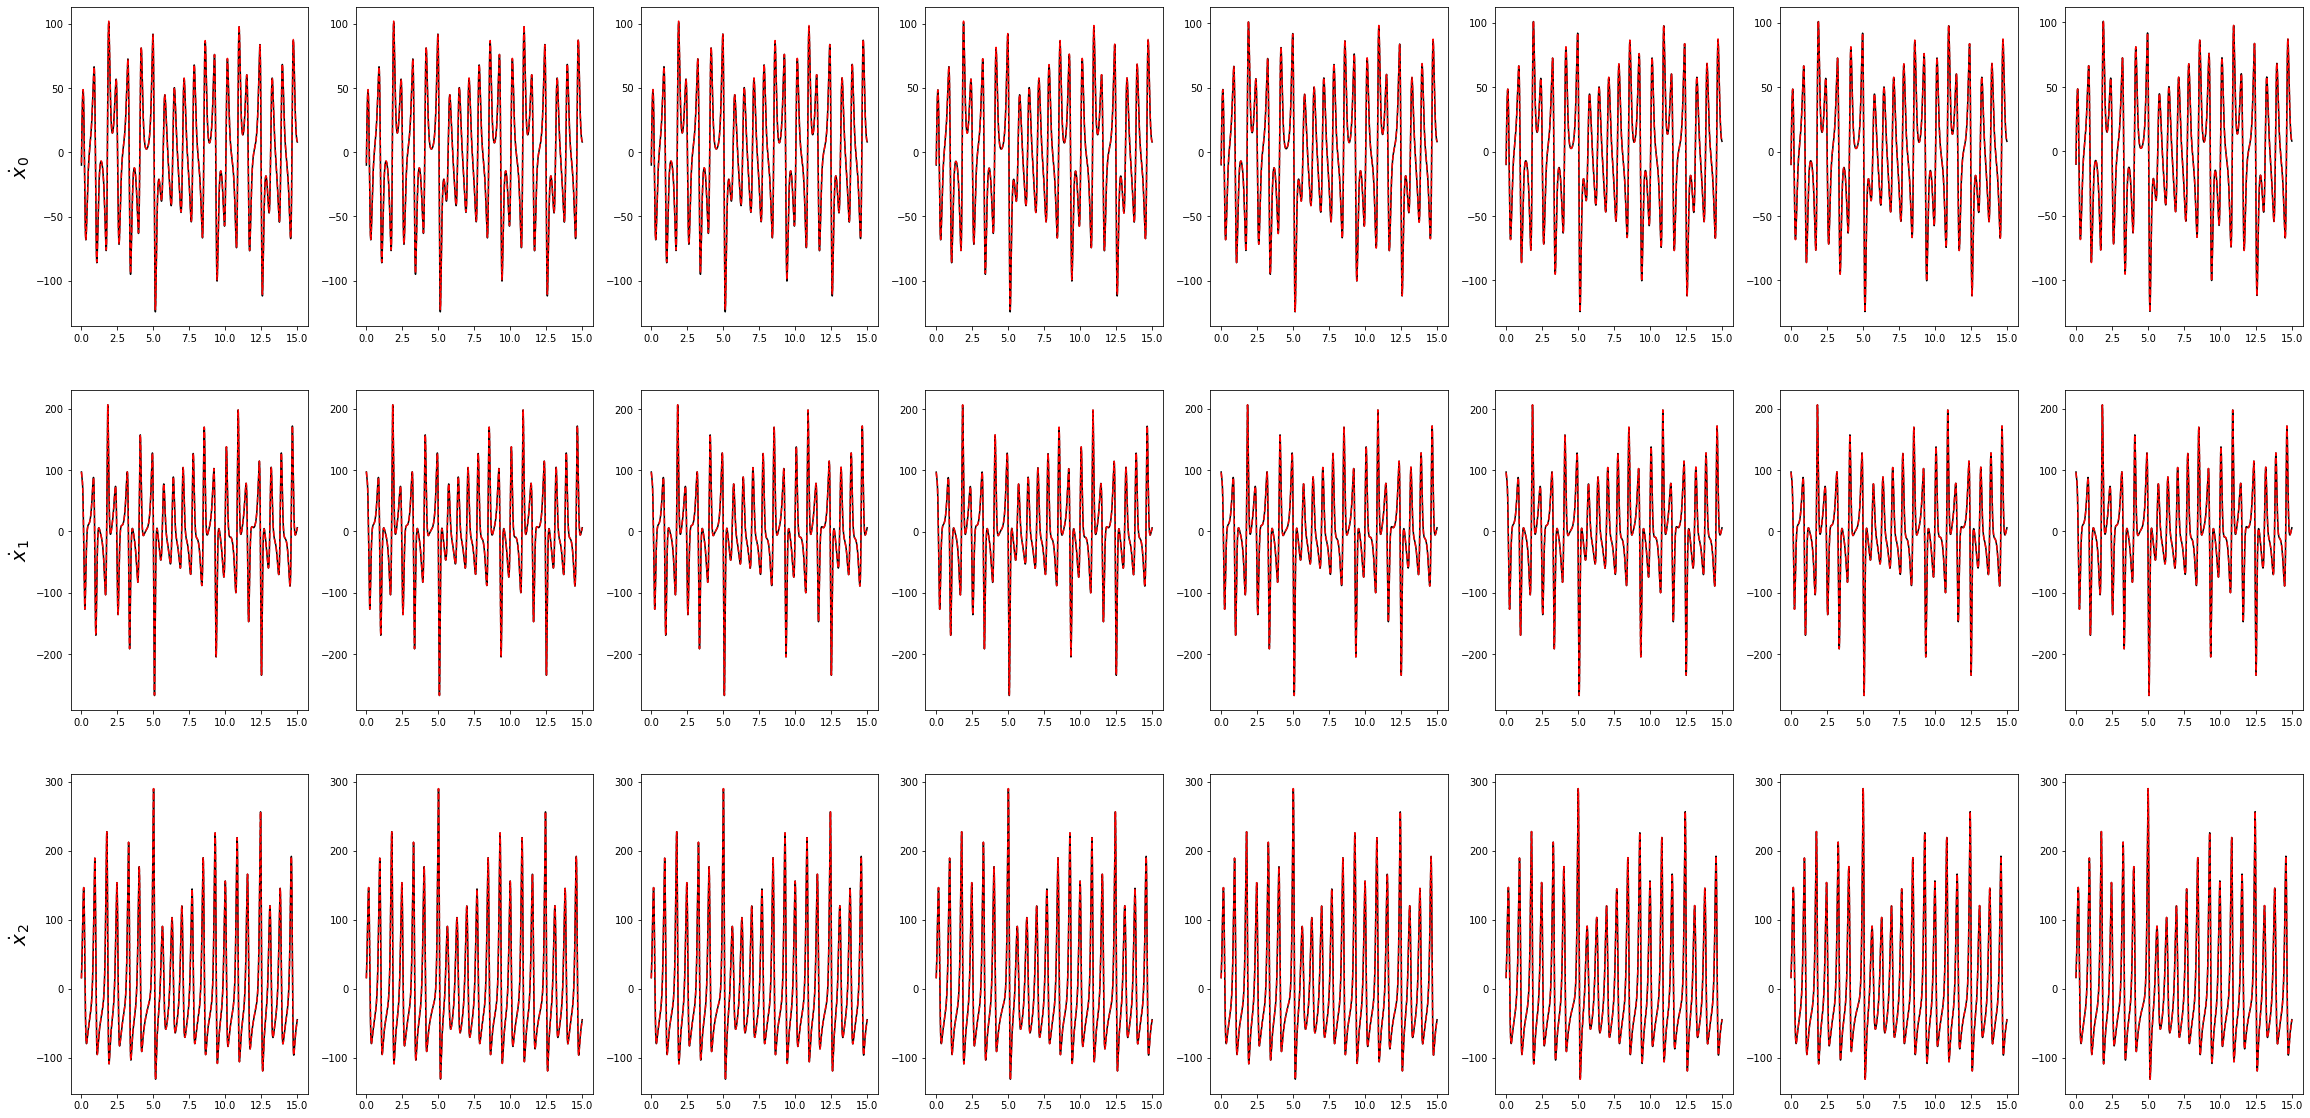

In [3]:
from sklearn.metrics import mean_squared_error

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)  

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_dot_test_computed[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_dot_test_predicted[:, i],
                    'r--', label='model prediction')
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

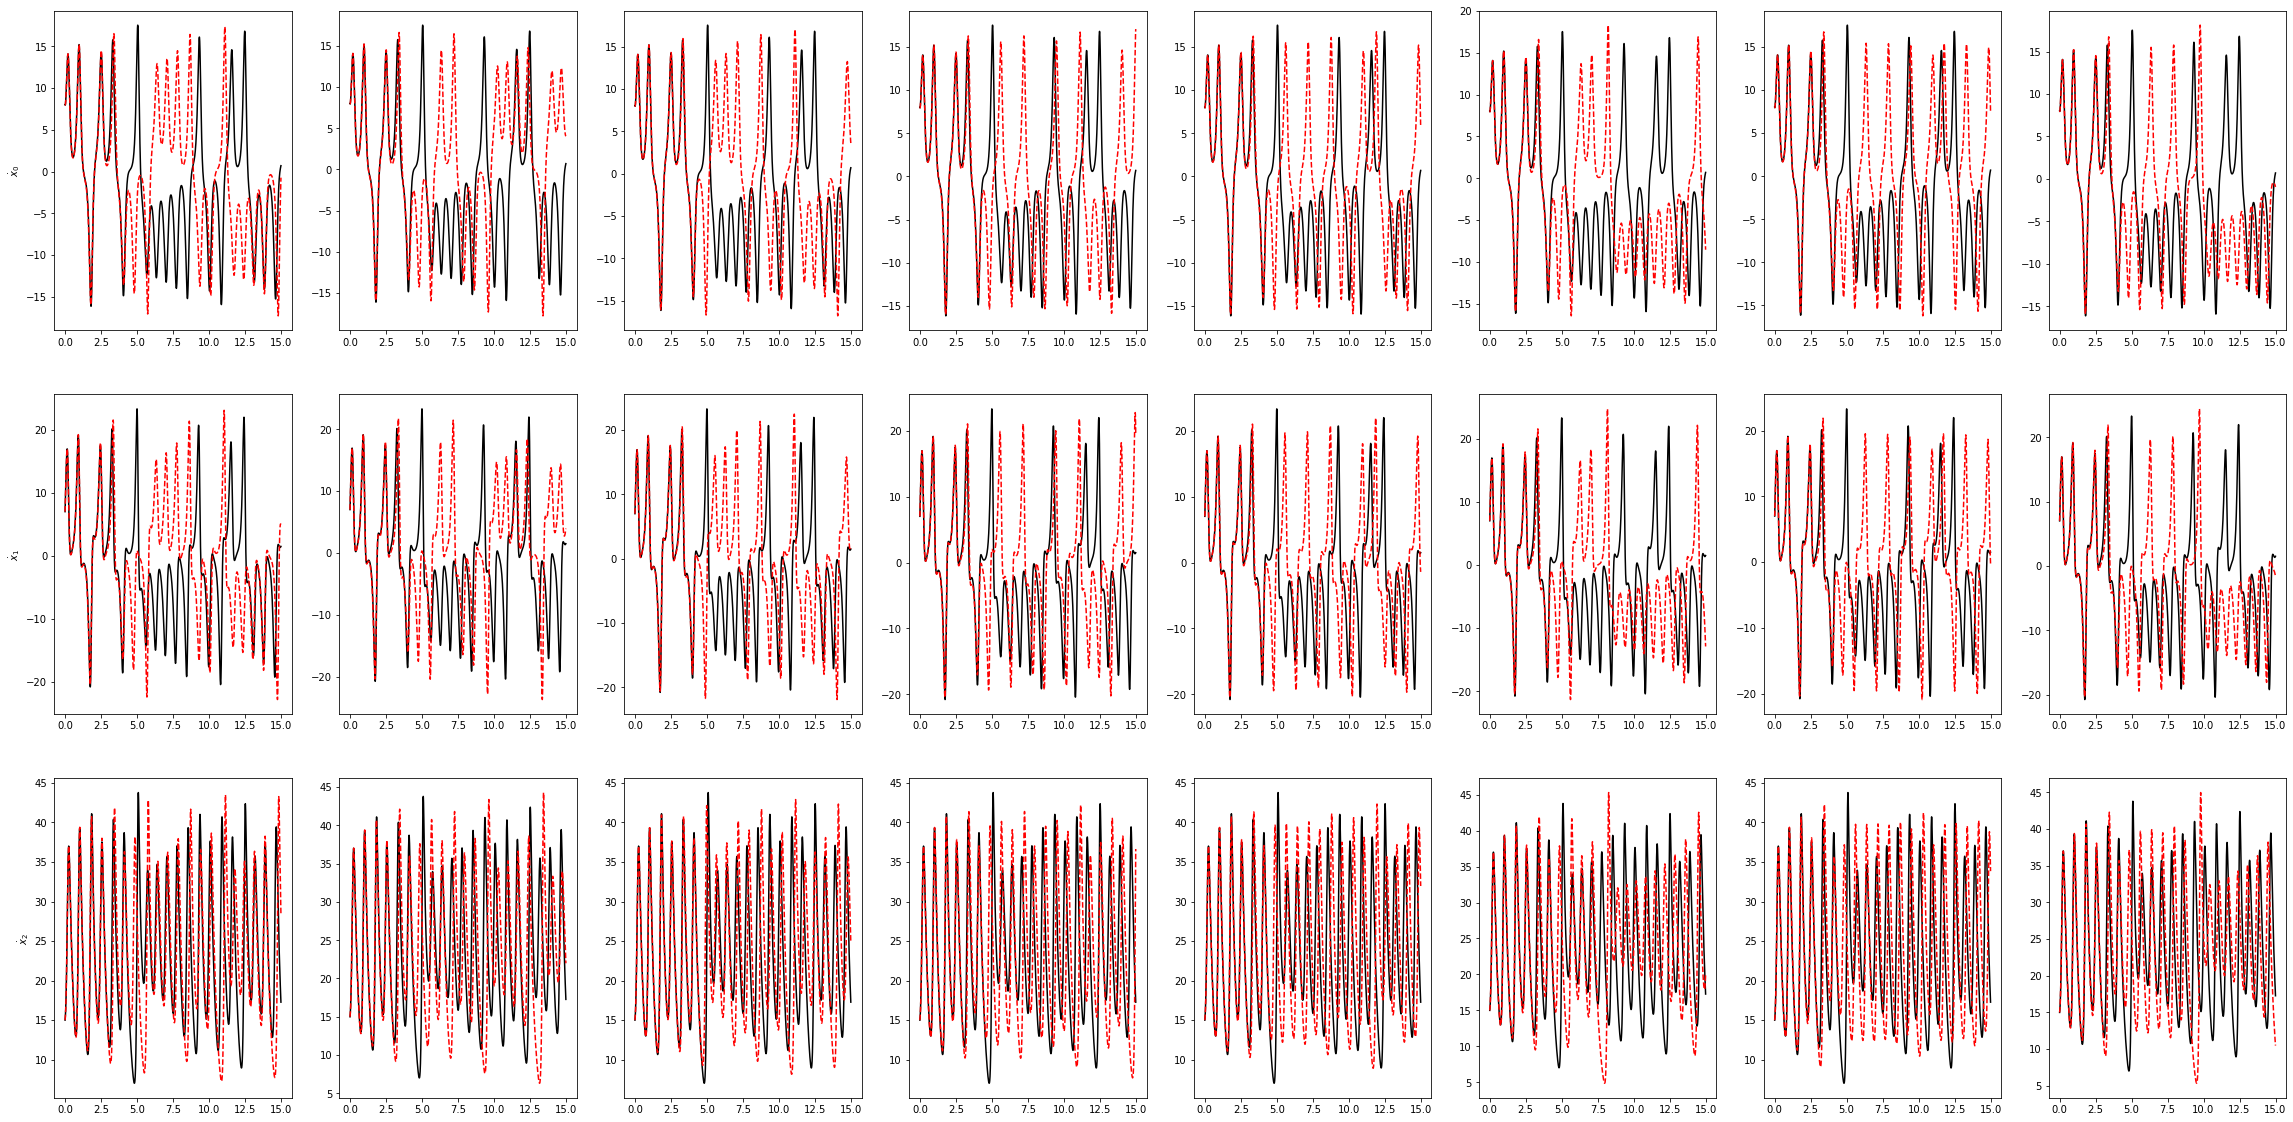

In [4]:
# Repeat plots but now integrate the ODE and compare the test trajectories
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    x_test_sim = model.simulate(x0_test, t_test)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_test[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_test_sim[:, i],
                    'r--', label='model prediction')  
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i))

# Repeat the SSR fitting with the lowest model residual method

In [5]:
ssr_optimizer = ps.SSR(alpha=.05, criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=SSR(criteria='model_residual'))

Model 0, MSE: 0.137894
Model 1, MSE: 0.132621
Model 2, MSE: 0.120663
Model 3, MSE: 0.099099
Model 4, MSE: 0.089426
Model 5, MSE: 0.071340
Model 6, MSE: 0.042290
Model 7, MSE: 0.089237


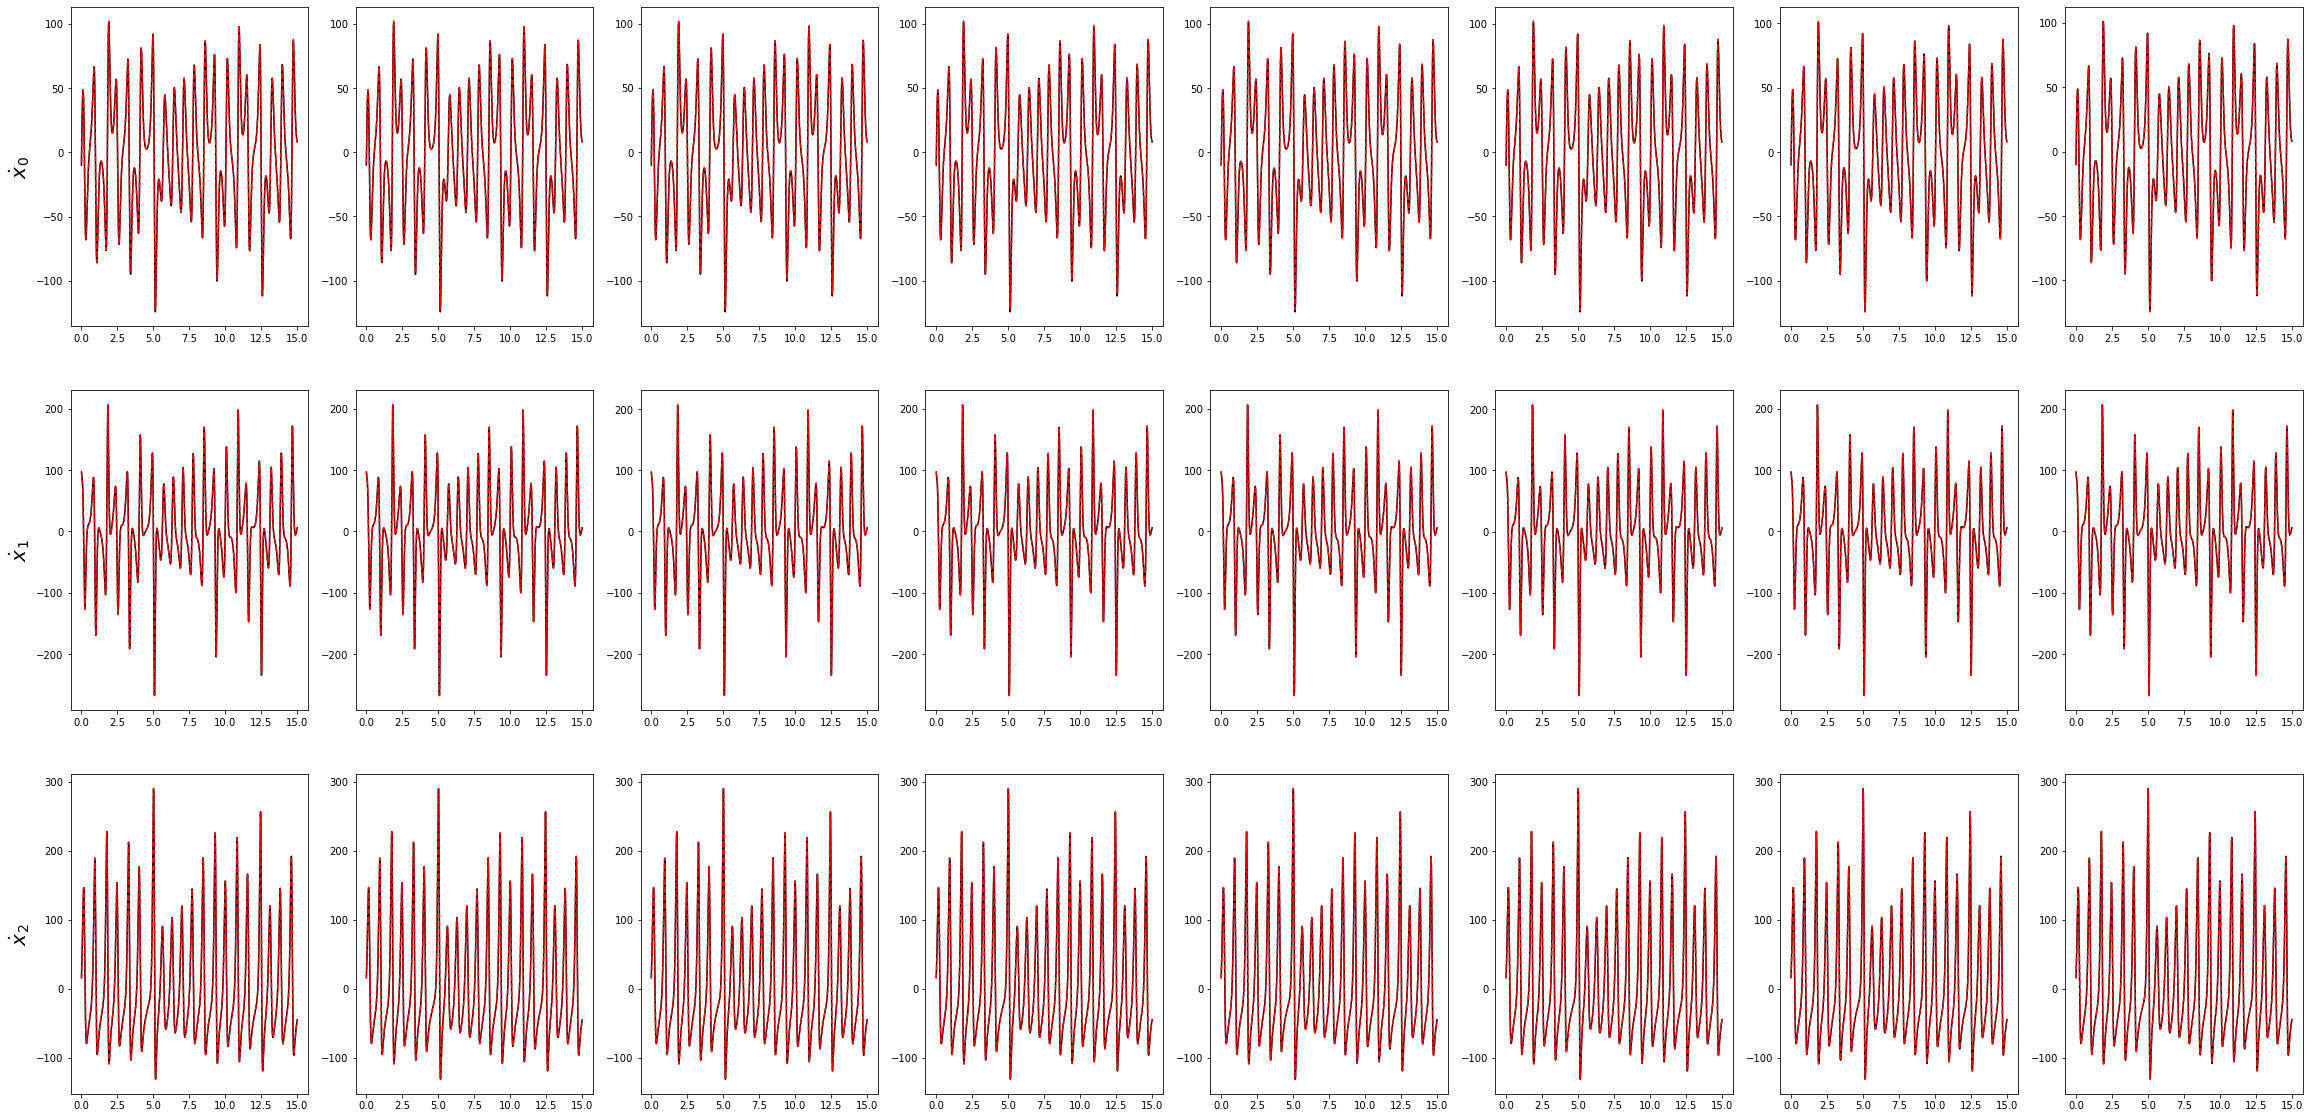

In [6]:
# Plot fits of the derivatives
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)  

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_dot_test_computed[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_dot_test_predicted[:, i],
                    'r--', label='model prediction')
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

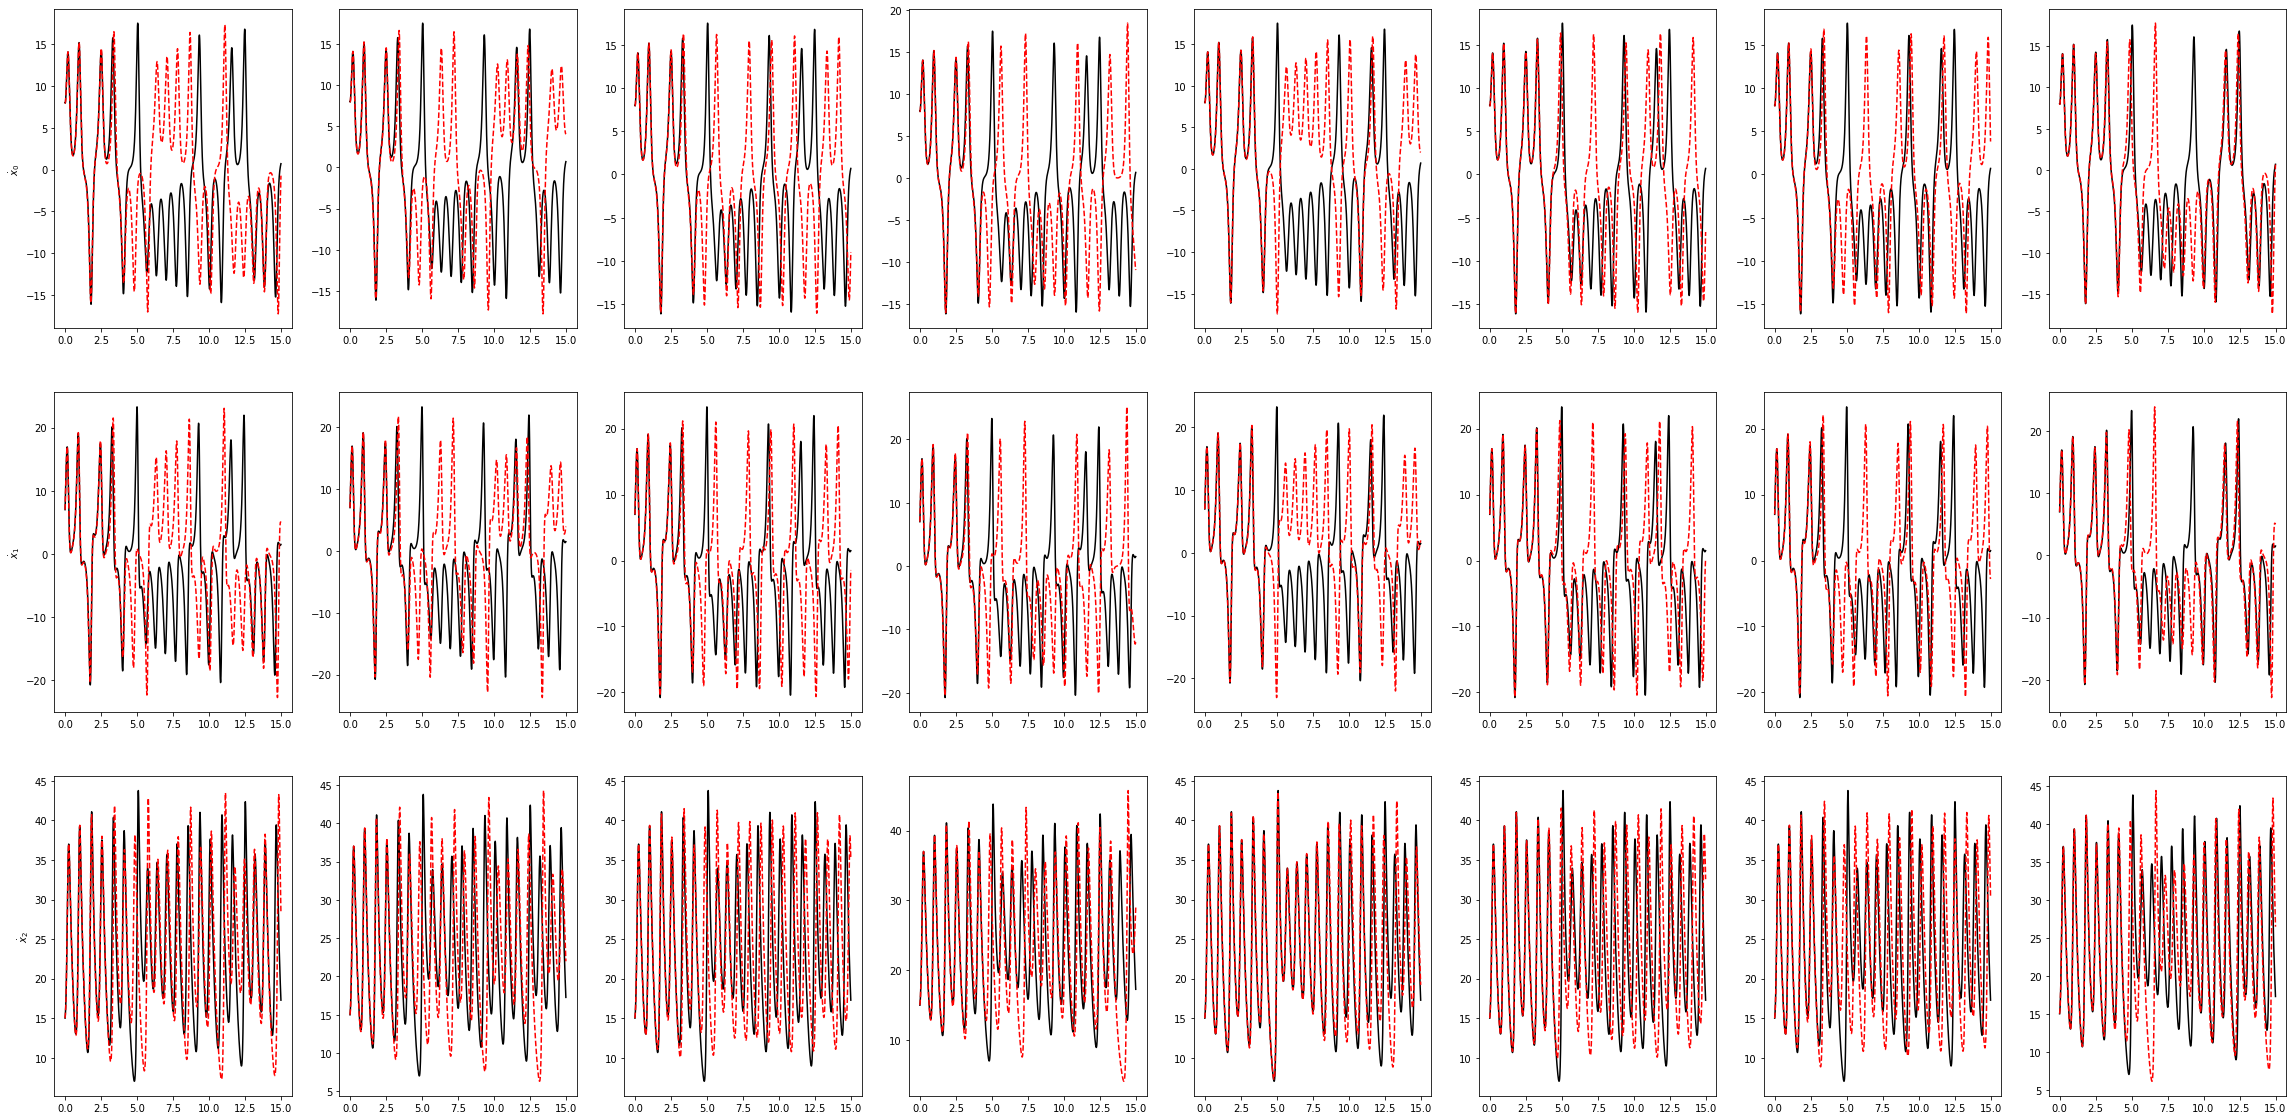

In [7]:
# Plot fits of the test trajectories
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    x_test_sim = model.simulate(x0_test, t_test)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_test[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_test_sim[:, i],
                    'r--', label='model prediction')  
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i))

# FROLS greedy algorithm
Forward Regression Orthogonal Least Squares (FROLS) solves the least-squares regression problem with $L_0$ norm by iteratively selecting the most correlated function in the library. At each step, the candidate functions are orthogonalized with respect to the already-selected functions. The selection criteria is the Error Reduction Ratio, i.e. the normalized increase in the explained output variance due to the addition of a given function to the basis.

In [8]:
frols_optimizer = ps.FROLS(kappa=1e-9)

model = ps.SINDy(optimizer=frols_optimizer)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=FROLS(kappa=1e-09))

MSE: 0.026945


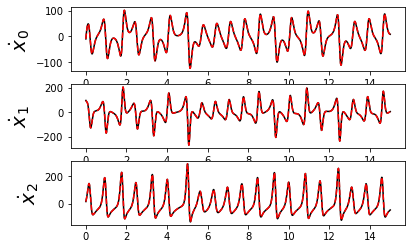

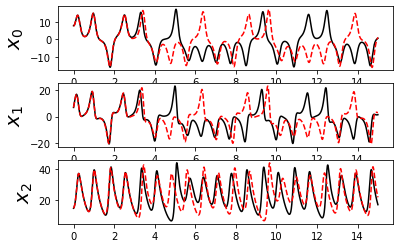

In [9]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

plt.figure()
for i in range(x_test.shape[1]):
    plt.subplot(np.shape(x_test)[1], 1, i+1)
    plt.plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    plt.plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)

print('MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

# Predict trajectories using the learned model
x_test_sim = model.simulate(x0_test, t_test)

plt.figure()
for i in range(x_test.shape[1]):
    plt.subplot(np.shape(x_test)[1], 1, i+1)
    plt.plot(t_test, x_test[:, i],
                'k', label='numerical derivative')
    plt.plot(t_test, x_test_sim[:, i],
                'r--', label='model prediction')  
    plt.ylabel('$x_{}$'.format(i), fontsize=20)

Model 0, MSE: 4374.241419
Model 1, MSE: 2332.158255
Model 2, MSE: 200.962619
Model 3, MSE: 8452.057487
Model 4, MSE: 5924.165907
Model 5, MSE: 16317.027130
Model 6, MSE: 16216.845617
Model 7, MSE: 16351.247285
Model 8, MSE: 15784.193979
Model 9, MSE: 15735.293029


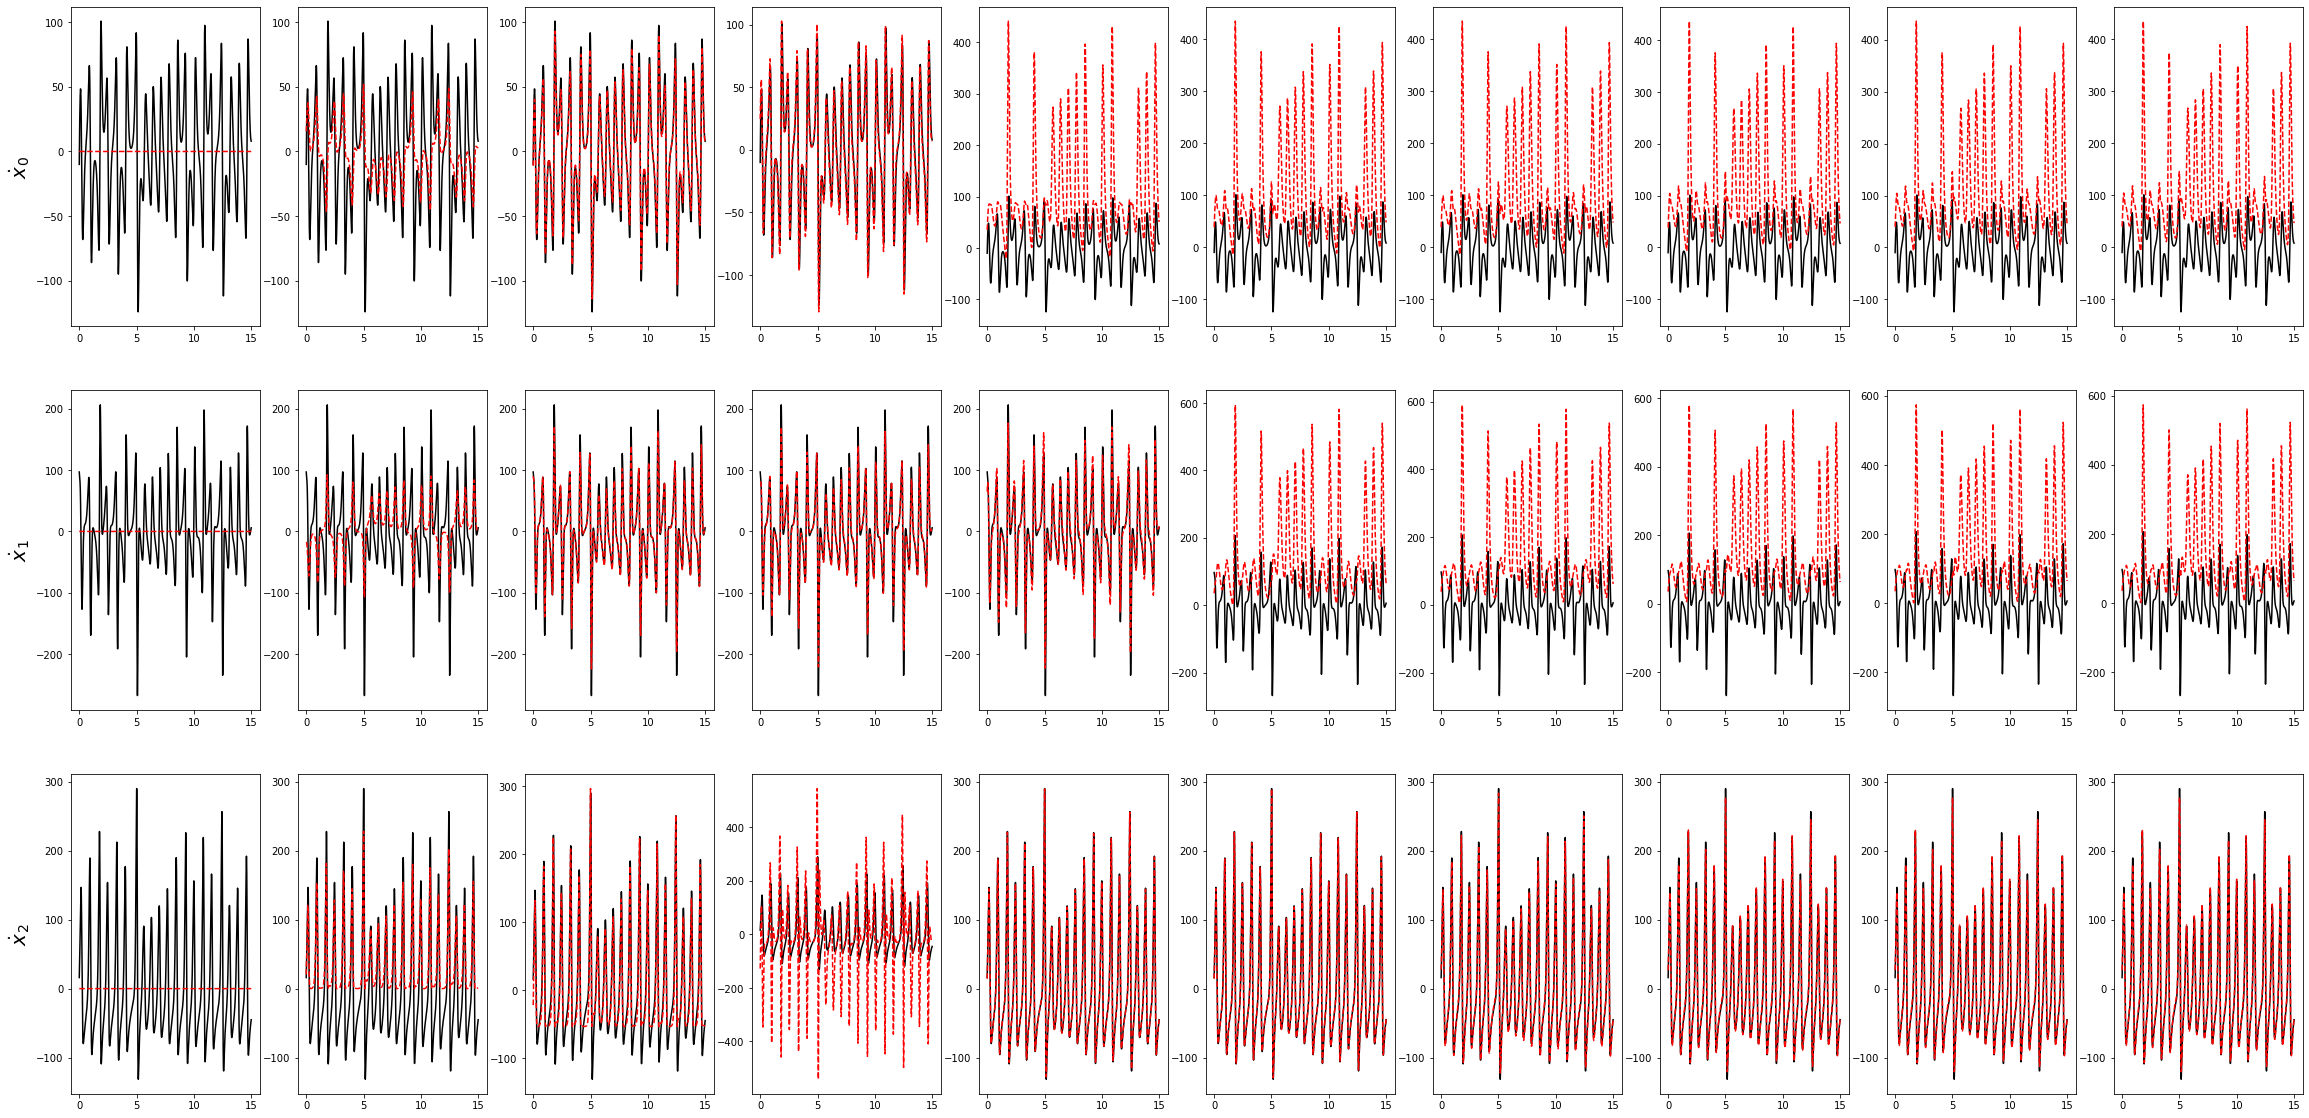

In [10]:
# Plot fits of the derivatives for all the generated models
plt.figure(figsize=(40, 20))
for j in range(np.shape(frols_optimizer.history_)[0]):
    frols_optimizer.coef_ = np.asarray(frols_optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)  

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(frols_optimizer.history_)[0], 
                    i * np.shape(frols_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_dot_test_computed[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_dot_test_predicted[:, i],
                    'r--', label='model prediction')
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_

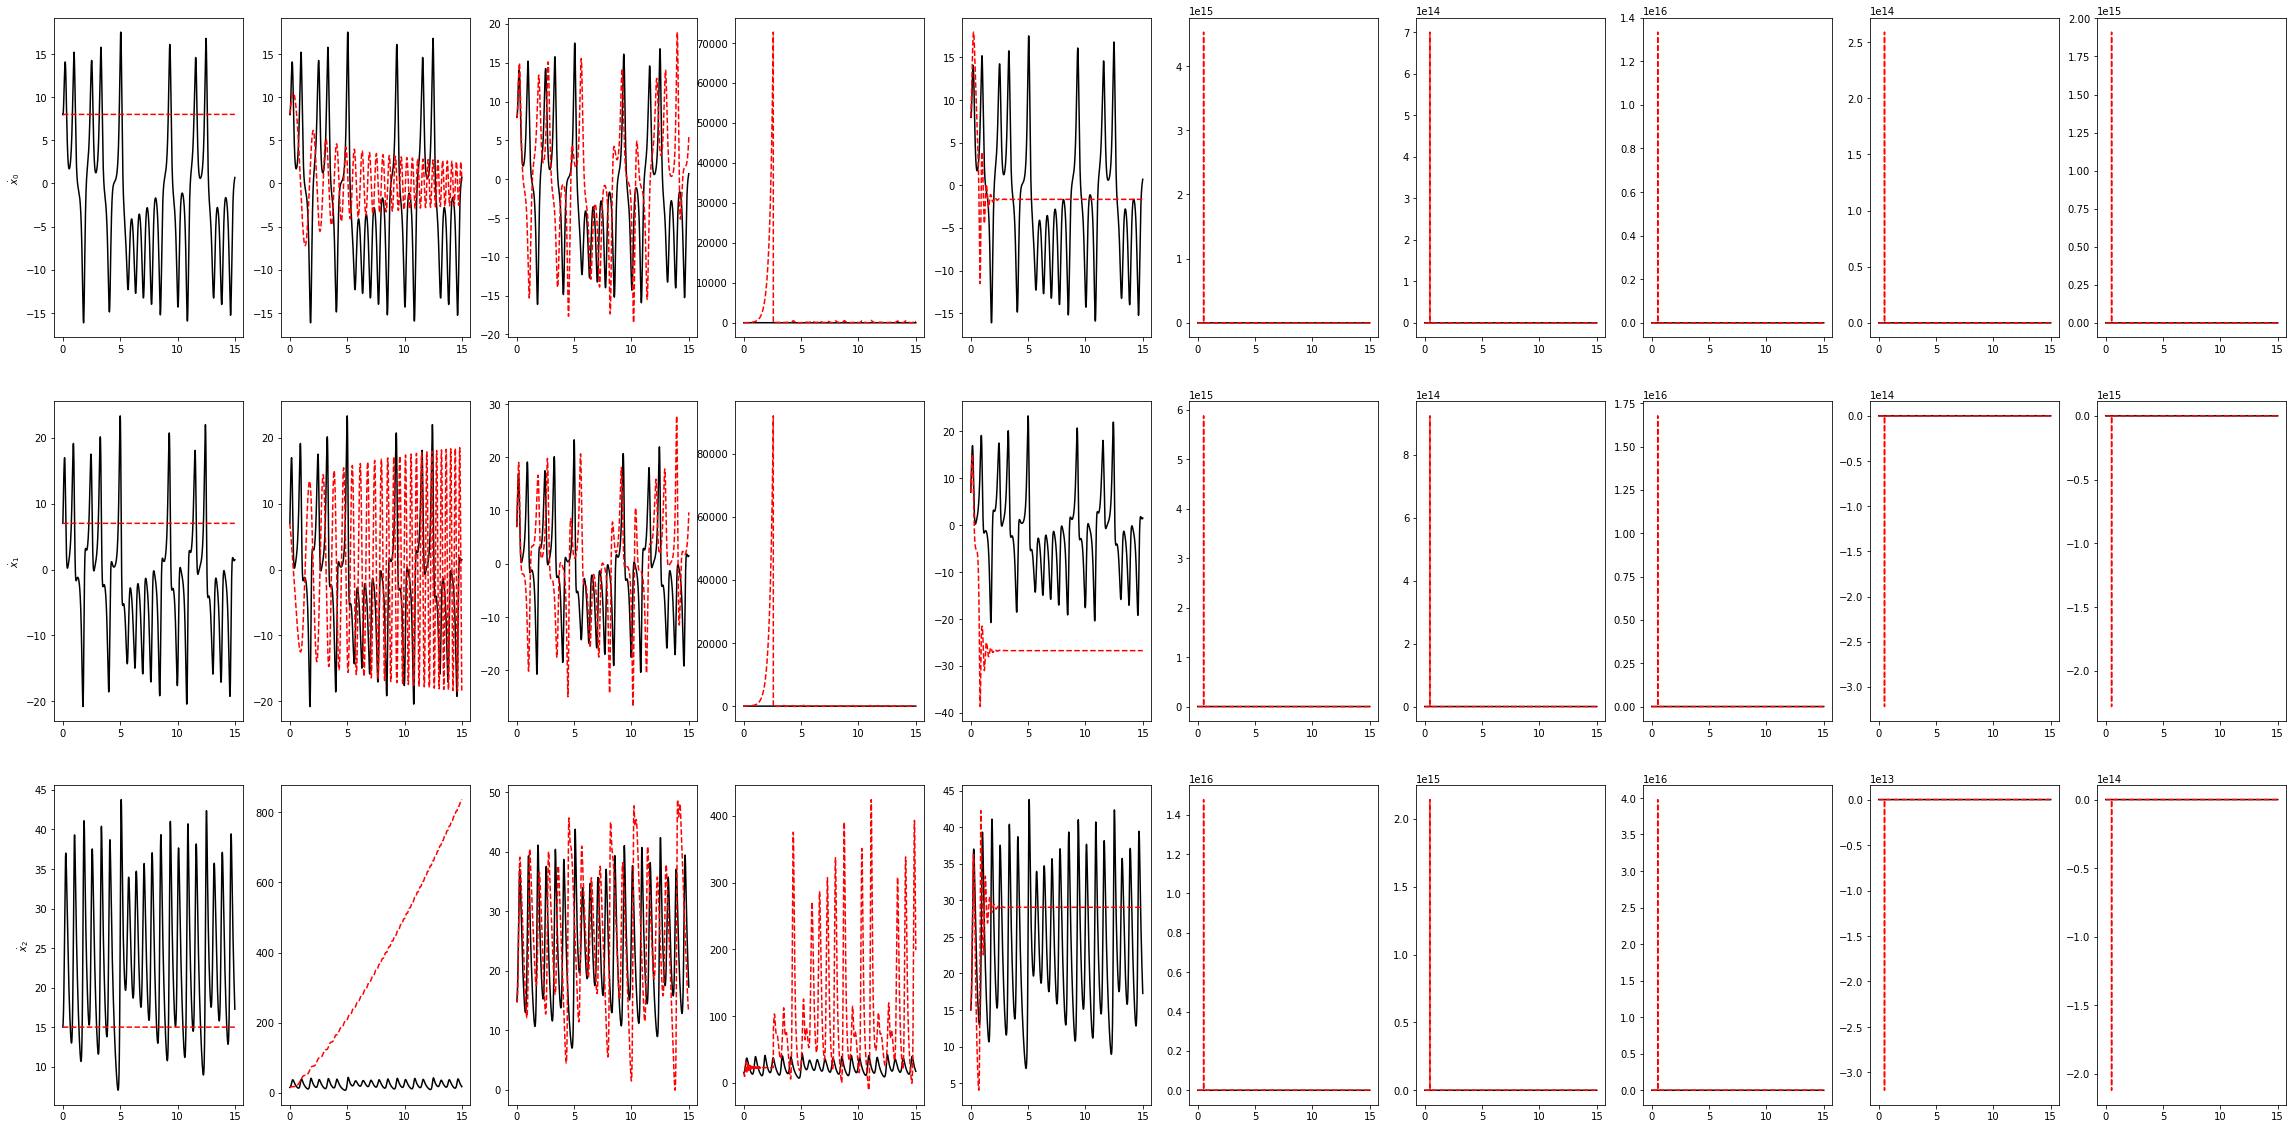

In [11]:
# Repeat plots but now integrate the ODE and compare the test trajectories
plt.figure(figsize=(40, 20))
for j in range(np.shape(frols_optimizer.history_)[0]):
    frols_optimizer.coef_ = np.asarray(frols_optimizer.history_)[j, :, :]
    
    x_test_sim = model.simulate(x0_test, t_test)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(frols_optimizer.history_)[0], 
                    i * np.shape(frols_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_test[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_test_sim[:, i],
                    'r--', label='model prediction')  
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i))

# Let's compare all three methods as the noise steadily increases, cross-validated over 20 noise instantiations

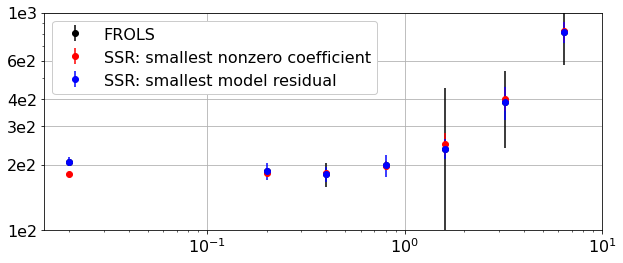

In [12]:
# generate training and testing data
dt = .1
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

# Cross-validate over 10 discharges for each noise level
n_validation = 10
noise_levels = [0.02, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
criterias = ["coefficient_value", "model_residual"]
final_MSE = np.zeros((3, len(noise_levels), n_validation))
for k, noise_level in enumerate(noise_levels):
    for i in range(n_validation):
        x_noisy = x_train + np.random.normal(0, noise_level, x_train.shape)
        for kk in range(3): 
            if kk == 0:
                optimizer = ps.SSR(alpha=0, criteria="coefficient_value")
            if kk == 1:
                optimizer = ps.SSR(alpha=0, criteria="model_residual")
            if kk == 2:
                optimizer = ps.FROLS()
            model = ps.SINDy(optimizer=optimizer)
            model.fit(x_noisy, t=dt)
            MSE = np.zeros(np.shape(optimizer.history_)[0])
            for j in range(np.shape(optimizer.history_)[0]):
                optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]
                MSE[j] = model.score(x_test, t=dt, metric=mean_squared_error)
            final_MSE[kk, k, i] = np.min(MSE)
            
average_MSE_cross_validated = np.mean(final_MSE, axis=-1)
std_MSE_cross_validated = np.std(final_MSE, axis=-1)

# Plot average MSE results with error bars.
# Note we are not including a sparsity penalty in the error term.
plt.figure(figsize=(10, 4))
plt.errorbar(noise_levels, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[2, :], fmt='o', color='k',
             label='FROLS')
plt.errorbar(noise_levels, average_MSE_cross_validated[0, :], 
             yerr=std_MSE_cross_validated[0, :], fmt='o', color='r', 
             label='SSR: smallest nonzero coefficient')
plt.errorbar(noise_levels, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[1, :], fmt='o', color='b',
             label='SSR: smallest model residual')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=16, loc='upper left', framealpha=1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_xticks([0.1, 1.0, 10])
ax.set_yticks([1e2, 2e2, 3e2, 4e2, 6e2, 10e2])
ax.set_yticklabels(['1e2', '2e2', '3e2', '4e2', '6e2', '1e3'])
plt.ylim(1e2, 10e2)
plt.savefig('SSR_FROLS_comparison.pdf')

### FROLs models are not handling the noise well, although the lowest MSE model seems to work fine. As usual, ensembling can help improve the robustness!

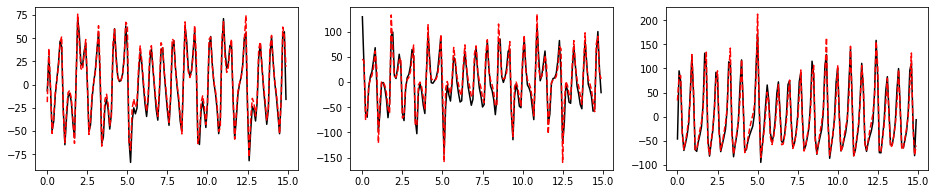

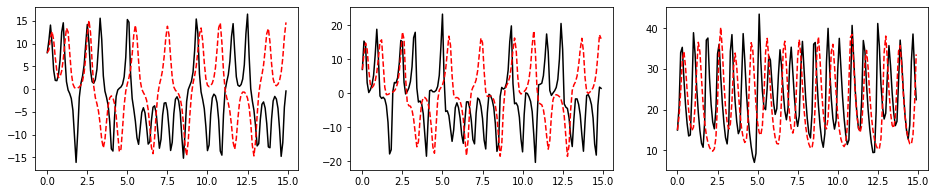

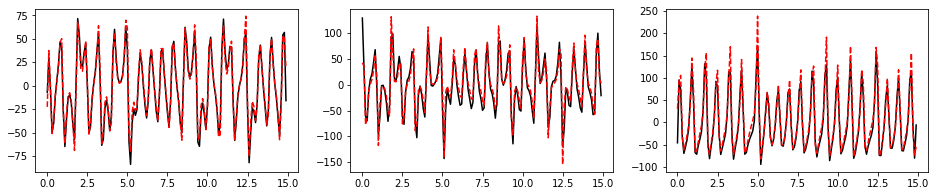

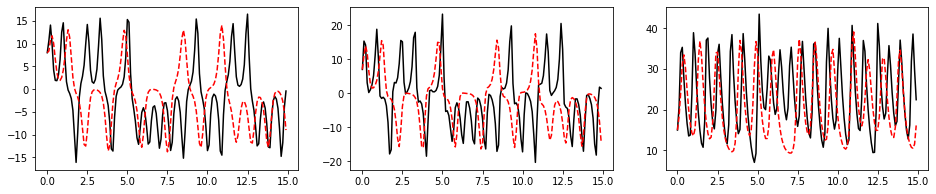

In [13]:
frols_optimizer = ps.FROLS(kappa=1e-7, max_iter=10)

model = ps.SINDy(optimizer=frols_optimizer)
model.fit(x_train, t=dt, ensemble=True)

# Take average of the lowest error models  (bagging)
frols_optimizer.coef_ = np.mean(np.asarray(model.coef_list), axis=0)

# Predict derivative using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivative and trajectory
x_dot_test_computed = model.differentiate(x_test, t=dt)
x_test_sim = model.simulate(x0_test, t_test)

plt.figure(figsize=(16, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    plt.plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    
plt.figure(figsize=(16, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_test, x_test[:, i],
                'k', label='numerical derivative')
    plt.plot(t_test, x_test_sim[:, i],
                'r--', label='model prediction')
    
# Repeat using the median (bragging)
frols_optimizer.coef_ = np.median(np.asarray(model.coef_list), axis=0)

# Predict derivative using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivative and trajectory
x_dot_test_computed = model.differentiate(x_test, t=dt)
x_test_sim = model.simulate(x0_test, t_test)

plt.figure(figsize=(16, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    plt.plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    
plt.figure(figsize=(16, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_test, x_test[:, i],
                'k', label='numerical derivative')
    plt.plot(t_test, x_test_sim[:, i],
                'r--', label='model prediction')